<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/text_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# テキスト分類のタスクを実行
### 使用するデータセットの参考文献
 - https://www.rondhuit.com/download.html#ldcc

### 右上の「接続」をクリックし、ランタイムに接続

## ライブラリをインストール

In [1]:
! pip uninstall -y thinc spacy fastai # 競合するライブラリを削除
! pip install scikit-learn==1.3.2 #ライブラリのverによっては次元圧縮の挙動が異なることがあるため注意
! pip install numpy==1.26.4
! pip install pandas==2.2.2
! pip install umap-learn==0.5.5

Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: spacy 3.8.5
Uninstalling spacy-3.8.5:
  Successfully uninstalled spacy-3.8.5
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 540.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) .

### 「ランタイム」タブから「セッションを再起動する」を選択し、「はい」をクリック

## データセットのダウンロード
 - https://www.rondhuit.com/download.html#ldcc からldcc-20140209.tar.gzをダウンロード

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、ldcc-20140209.tar.gzをドラッグ＆ドロップしてアップロード
# ldcc-20140209.tar.gzrを以下のコマンドで解凍する
!mv ldcc-20140209.tar.gz ldcc-20140209.tar
!tar xvf ldcc-20140209.tar > /dev/null

In [3]:
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [4]:
import gc
import glob
import os

import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import umap
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## グラフ表示の際のフォント種類やフォントサイズを設定

In [5]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20

## データを読み込み、データフレームに格納

In [6]:
# ファイルの読み込み関数
def read_file(file_path):
    with open(file_path, "r") as f:
        text = f.read()
    return text

# 1フォルダの読み込み関数
def read_folder(folder_path):
    folder_name = os.path.basename(folder_path)
    files = sorted(glob.glob(os.path.join(folder_path, f"{folder_name}*.txt")))  # フォルダ名で始まるファイルのみ取得
    texts = [read_file(file) for file in files]
    return texts

# フォルダのパスを取得
folder_paths = sorted(glob.glob(os.path.join(INPUT_FILE_PATH, "text", "*")))

# フォルダごとにデータフレームを作成
dfs = []
for folder_path in tqdm(folder_paths):
    folder_name = os.path.basename(folder_path)
    texts = read_folder(folder_path)
    df = pd.DataFrame({"text": texts, "label": folder_name})
    dfs.append(df)

# 各データフレームを結合
df = pd.concat(dfs, ignore_index=True)

# labelごとのデータ数を確認
print(df["label"].value_counts())


  0%|          | 0/11 [00:00<?, ?it/s]

label
sports-watch      900
dokujo-tsushin    870
it-life-hack      870
movie-enter       870
smax              870
kaden-channel     864
peachy            842
topic-news        770
livedoor-homme    511
Name: count, dtype: int64


In [7]:
len(df)

7367

## データの前処理

In [8]:
# df['text']の文章からhttps://～を削除する
df["text"] = df["text"].str.replace(
    "https?://[\w/:%#\$&\?\(\)~\.=\+\-]+", "", regex=True
)
# df['text']の文章から改行コードを削除する
df["text"] = df["text"].str.replace("\n", "", regex=True)

## Transformer系列のモデルを用いたベクトル化を行う

In [9]:
# モデルの読み込み
model = SentenceTransformer("hotchpotch/static-embedding-japanese", device="cpu") #CPUで実行

# ベクトル化
vectors = model.encode(df["text"].values, show_progress_bar=True)

modules.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

Batches:   0%|          | 0/231 [00:00<?, ?it/s]

In [10]:
len(vectors)

7367

In [11]:
# vectorsをデータフレームに変換
vectors_df = pd.DataFrame(vectors)
vectors_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.022241,-0.406272,-0.671114,0.101785,-0.267815,-0.469713,0.572694,0.063506,0.053134,-0.033618,...,-0.260793,-0.037743,-0.436151,0.247454,-0.528911,-0.159708,0.054010,-0.178509,0.448184,0.068358
1,-0.960274,-0.160943,-0.498987,-0.156221,-0.276187,-0.050916,-0.061693,-0.269395,-0.420498,0.120312,...,-0.077155,-0.162742,-0.303049,-0.825299,-0.652556,-0.013068,-0.592038,0.067164,-0.203017,0.052555
2,0.201092,0.220550,-0.433975,-0.344399,0.138076,-0.245252,0.427343,-0.515697,-0.254491,-0.334119,...,-0.404145,-0.225605,0.051255,-0.341367,0.036047,0.012773,-0.131301,-0.692108,0.804073,-0.158191
3,0.100988,-0.049348,-0.175594,-0.487281,-0.024229,-0.239076,-0.127207,-0.296543,0.236379,0.066521,...,-0.165105,0.112108,0.261708,-0.212212,0.093347,0.079755,0.197205,-0.027065,0.570109,-0.429719
4,-0.338039,0.025743,-0.667926,0.076997,-0.094071,0.910365,-0.862697,0.672980,-0.474212,0.109707,...,0.539243,-0.052114,-0.466754,0.251991,0.000580,0.046340,-0.096413,0.075072,-0.037400,-0.339378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7362,-0.249107,0.358202,-0.612199,-0.105881,-0.243924,0.172910,-0.295615,-0.700271,-0.841858,0.201915,...,-0.125145,-0.168036,-0.409374,-0.193360,0.235498,0.445679,-0.720912,-0.456565,0.168614,-0.096337
7363,0.353255,-0.059444,-1.100181,-0.399001,-0.169083,-0.318503,-0.853572,0.572244,0.266320,0.035258,...,0.020944,-0.128742,0.374779,-0.399772,-0.254714,0.312460,-0.165796,-0.099911,0.048871,-0.093642
7364,-0.433981,1.044925,0.154346,0.495337,-0.191083,0.251078,0.493185,-0.660846,-0.378396,0.377397,...,-0.280660,-0.388321,0.264020,0.267277,0.141669,0.656066,-0.081223,-0.812008,0.720224,0.967457
7365,-0.593399,0.808088,-0.172929,-0.701722,-0.423412,0.151196,0.631811,-0.208174,0.201044,-0.551585,...,-0.288131,-0.256406,-0.069504,0.299617,-0.343379,-0.001867,0.030462,-0.547634,-0.034746,0.845307


## ベクトル化したテキストデータをUMAPを用いて2次元空間に可視化する

In [12]:
# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42) # n_neighborsのデフォルト値は15
umap_result = umap_model.fit_transform(vectors)

# UMAPの結果をデータフレームに変換
umap_df = pd.DataFrame(umap_result, columns=["umap1", "umap2"])

# dfとumap_dfを結合
df = pd.concat([df, umap_df], axis=1)

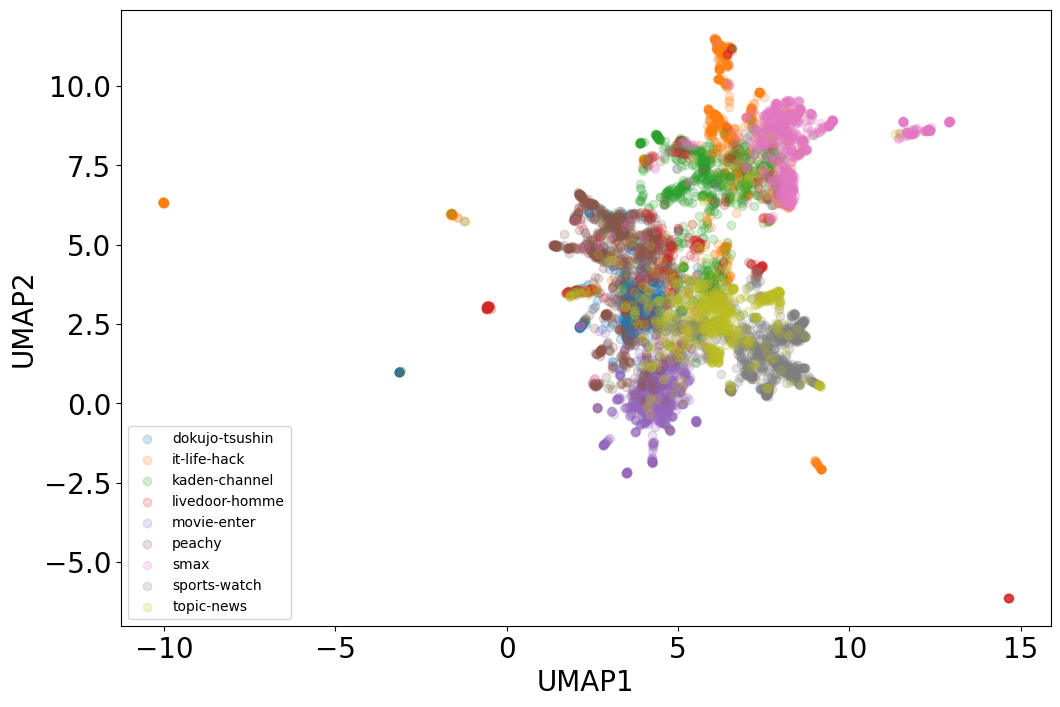

In [13]:
# umap1とumap2をプロット、labelごとに色分けして透過度を変える
plt.figure(figsize=(12, 8))
for label in df["label"].unique():
    plt.scatter(
        df[df["label"] == label]["umap1"],
        df[df["label"] == label]["umap2"],
        label=label,
        alpha=0.2,
    )
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(fontsize=10)
plt.show()

## 実行環境のライブラリverを保存

In [14]:
!pip freeze > requirements_text_clustering.txt

In [15]:
from google.colab import files

files.download('requirements_text_clustering.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>